Comments

- Check if Random Forest (or any other model) is overfitting and explain why
- Fine-tune the hyperparameters of the best 2 performing "traditional" Machine Learning models
- Try to run the best 2 performing models without Sampling the data ! (you can shuffle it if and only if the temporal information has been taken featue engineered not to lose info aka. timestamp)
- Incorporate the temporal imformation in the training of the traditional ML models too - Ask Hindy, it is related to the Data part of which Vidur is in charge
- Add AUROC as a evaluation metrics
- Build an ensemble tree method alongside debuging  KNN, SVM, LightGBM, etc.
- Look at past papers on our dataset and see if they have used other kind of tradutional models and how they have evaluated/interpreted it all


### Data Preparation

Before training models, there are still a few things we should do. Let us check imbalance in our dataset classes, resample, and later shuffle teh data. 


In [1]:
# import our data
import pickle

# Load the data from the pickle file
with open("train_test_data.pkl", "rb") as f:
    X_train_, X_test_, y_train_, y_test_ = pickle.load(f)

# Check the shapes of the imported data
print("X_train_final shape:", X_train_.shape)
print("X_test_final shape:", X_test_.shape)
print("y_train_encoded shape:", y_train_.shape)
print("y_test shape:", y_test_.shape)

print(y_test_)



X_train_final shape: (91589, 241)
X_test_final shape: (10177, 1538)
y_train_encoded shape: (91589,)
y_test shape: (10177,)
[2 1 2 ... 2 0 1]


In [2]:
import numpy as np

# Check class distribution
unique_classes, class_counts = np.unique(y_train_, return_counts=True)
class_distribution = dict(zip(unique_classes, class_counts))

print("Class Distribution in y_train_encoded:", class_distribution)

Class Distribution in y_train_encoded: {0: 10245, 1: 31989, 2: 49355}


As we can see, we need to oversample class 0 and downsample class 2. We do not use SMOTE or ASYN cause some dependency problems arise. 

In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import pandas as pd

# Step 1: Define the dataset
# Assuming X_train_final and y_train_encoded are your features and target
X_train = X_train_.copy()
y_train = y_train_.copy()

print("Original class distribution:")
print(Counter(y_train))  # Check initial distribution

# Step 2: Identify classes and their counts
classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()  # Count of the majority class

# Step 3: Initialize placeholders for synthetic samples
X_synthetic = []
y_synthetic = []

# Step 4: Oversample each minority class
k_neighbors = 5  # Number of neighbors for interpolation
for cls, count in zip(classes, counts):
    if count < max_count:  # Only oversample classes smaller than the majority class
        n_samples_to_generate = max_count - count  # Number of synthetic samples needed
        X_minority = X_train[y_train == cls]

        # Use NearestNeighbors to find neighbors in the minority class
        nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(X_minority)
        indices = nbrs.kneighbors(X_minority, return_distance=False)

        # Generate synthetic samples
        synthetic_samples = []
        for _ in range(n_samples_to_generate):
            idx = np.random.randint(0, X_minority.shape[0])  # Randomly pick a minority sample
            nn_idx = indices[idx][np.random.randint(1, k_neighbors)]  # Pick one of its neighbors
            diff = X_minority.iloc[nn_idx].values - X_minority.iloc[idx].values  # Difference vector
            synthetic_sample = X_minority.iloc[idx].values + np.random.rand() * diff  # Interpolation
            synthetic_samples.append(synthetic_sample)

        synthetic_samples = np.array(synthetic_samples)

        # Append synthetic samples and labels to placeholders
        X_synthetic.append(synthetic_samples)
        y_synthetic.append(np.full(n_samples_to_generate, cls))

# Step 5: Combine synthetic samples with the original dataset
X_synthetic = np.vstack(X_synthetic) if X_synthetic else np.empty((0, X_train.shape[1]))
y_synthetic = np.hstack(y_synthetic) if y_synthetic else np.empty((0,))

X_train_balanced = np.vstack([X_train, X_synthetic])
y_train_balanced = np.hstack([y_train, y_synthetic])

# Step 6: Verify the new class distribution
print("\nBalanced class distribution:")
print(Counter(y_train_balanced))

# Step 7: Output shapes
print("\nBalanced dataset shapes:")
print(f"Features shape: {X_train_balanced.shape}")
print(f"Target shape: {y_train_balanced.shape}")

Original class distribution:
Counter({2: 49355, 1: 31989, 0: 10245})


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [23]:
from sklearn.utils import shuffle

# Combine features and labels into a single dataset for shuffling
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

# Verify the shapes after shuffling
print("Shuffled dataset shapes:")
print(f"Features shape: {X_train_balanced.shape}")
print(f"Target shape: {y_train_balanced.shape}")

print(y_train_balanced)


Shuffled dataset shapes:
Features shape: (148065, 2367)
Target shape: (148065,)
[2 1 0 ... 1 1 0]


### Baseline Models
**Listed below are our baseline models**

- Logistic Regression
- LightGBM
- K-Nearest Neighbours
- XGBoost
- Support Vector Machine
- random Forest (not used because lacks explanability)
---
**Model evaluation and selection**
- Metrics like confusion matrices, classification reports ROC curves and AUC are generated for each respective model to evaluate their performances.
- K-fold cross validation and hyperparameter tuning will be applied to better-performing models to detect overfitting and achieve a better balance between overfitting and accuracy.


## 1. Logistic Regression

Elastic Net Regularisation

In [ ]:
# HERREEEEEEEE!!!

(118452, 2367) (29613, 2367) (118452,) (29613,)


/Users/hindy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model Performance:
Training Accuracy: 0.4987
Validation Accuracy: 0.4949
Accuracy Difference (Training - Validation): 0.0038
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.52      0.49      0.50     39349
readmitted_>30       0.46      0.43      0.44     39584
 readmitted_NO       0.52      0.58      0.55     39519

      accuracy                           0.50    118452
     macro avg       0.50      0.50      0.50    118452
  weighted avg       0.50      0.50      0.50    118452



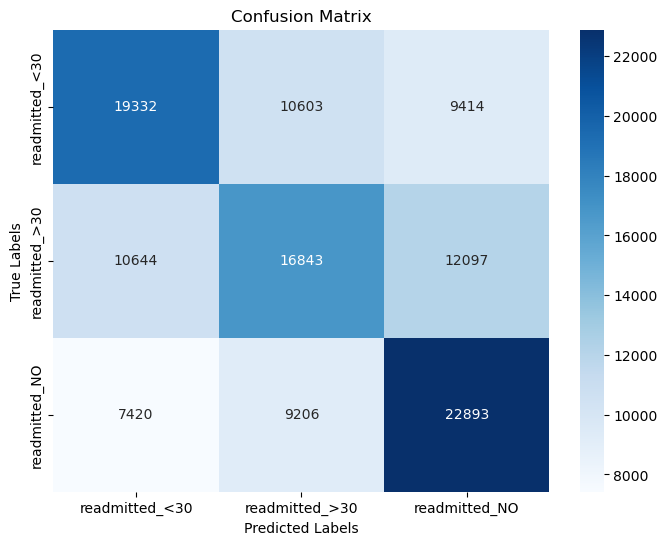

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42
)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# Step 2: Train the Logistic Regression model
logreg = LogisticRegression(
    solver='lbfgs',  
    multi_class='multinomial',  
    max_iter=1000,  
    random_state=42
)
logreg.fit(X_train, y_train)

# Step 3: Make predictions
y_train_pred = logreg.predict(X_train)
y_val_pred = logreg.predict(X_val)

# Step 4: Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")

# Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

/Users/hindy/anaconda3/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/Users/hindy/anaconda3/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/Users/hindy/anaconda3/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/Users/hindy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/hindy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/hindy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples

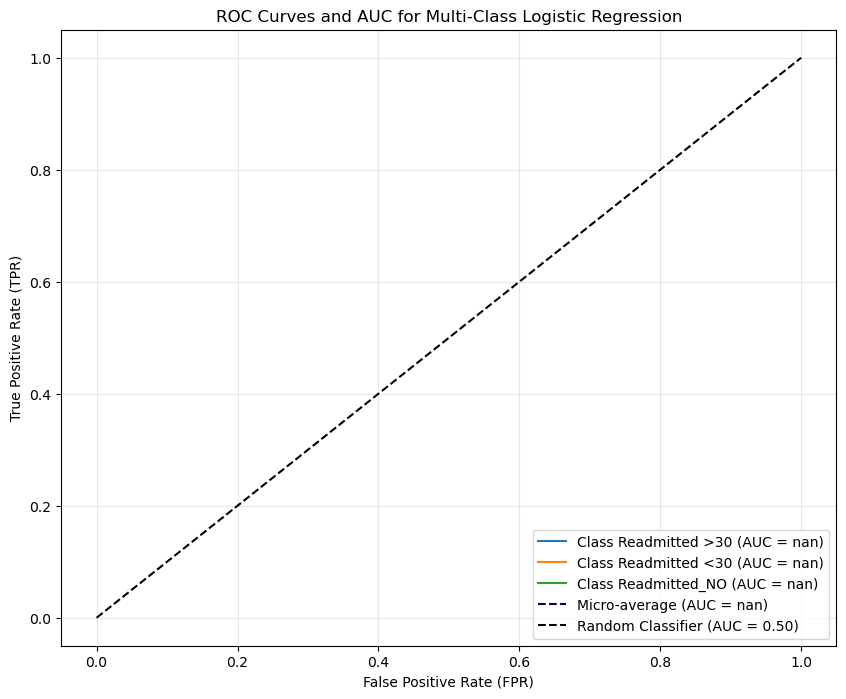

In [9]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels (required for multi-class ROC)
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']

y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Fit a one-vs-rest classifier (assuming Logistic Regression is used)
ovr_classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
ovr_classifier.fit(X_train, label_binarize(y_train, classes=[0, 1, 2]))
y_pred_proba = ovr_classifier.decision_function(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Multi-Class Logistic Regression")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Although this model doesn't overfit, it doesn't have a great performance thus we wouldn't be tuning its hyperparameters to achieve a better accuracy

## 2. LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17340
[LightGBM] [Info] Number of data points in the train set: 94812, number of used features: 68
[LightGBM] [Info] Start training from score -1.100259
[LightGBM] [Info] Start training from score -1.097126
[LightGBM] [Info] Start training from score -1.098454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

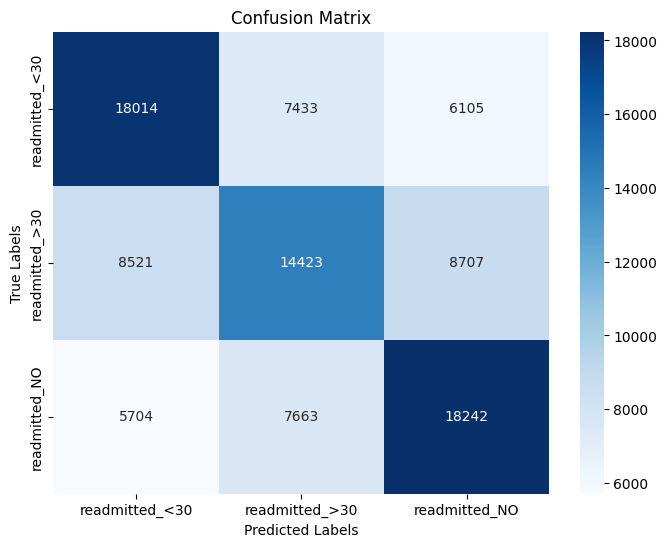

In [199]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Train the LightBGM model
lgbm_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        max_depth=4,
    )
lgbm_model.fit(X_train, y_train)

# Step 2: Make predictions
y_train_pred = lgbm_model.predict(X_train)
y_val_pred = lgbm_model.predict(X_val)

# Step 3: Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

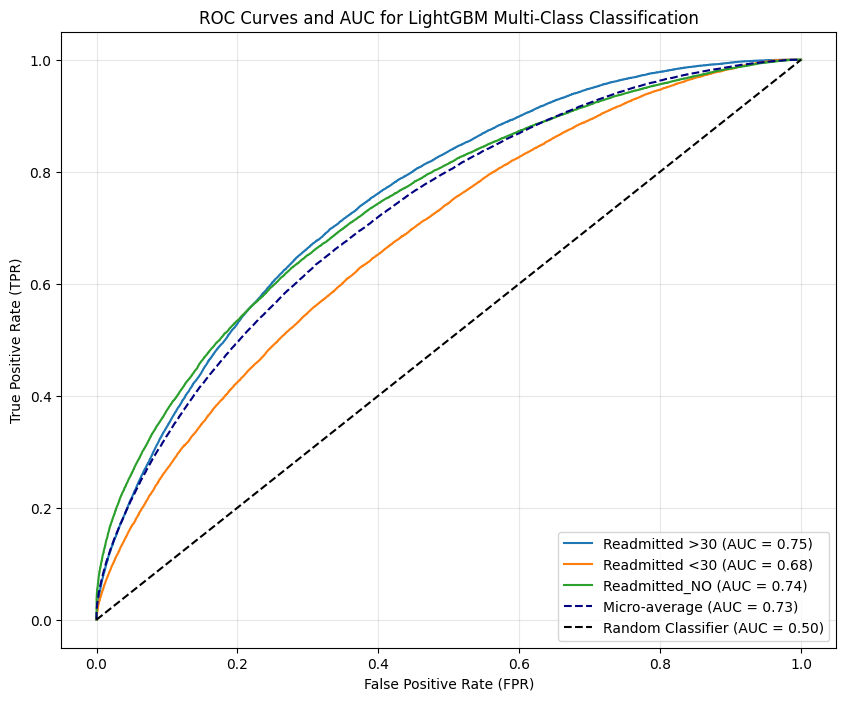

In [200]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = lgbm_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for LightGBM Multi-Class Classification")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Similar to the logistic regression model, although this model shows no sign of overfitting, we are still not going to tune the hyperparameters due to its poor performance

## 3. KNN Classifier



Model Performance:
Training Accuracy: 0.7505
Validation Accuracy: 0.6397
Accuracy Difference (Training - Validation): 0.1108
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.72      0.98      0.83     31552
readmitted_>30       0.74      0.72      0.73     31651
 readmitted_NO       0.82      0.56      0.66     31609

      accuracy                           0.75     94812
     macro avg       0.76      0.75      0.74     94812
  weighted avg       0.76      0.75      0.74     94812



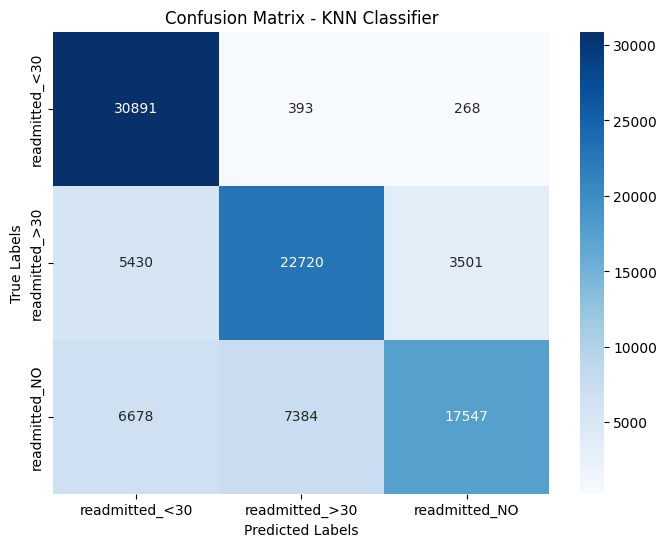

In [201]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Train KNN model
knn_model = KNeighborsClassifier(
    n_neighbors=5,  # You can adjust this parameter
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,  # Euclidean distance
    metric='minkowski',
)
knn_model.fit(X_train, y_train)

# Make predictions
y_train_pred = knn_model.predict(X_train)
y_val_pred = knn_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"],
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - KNN Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

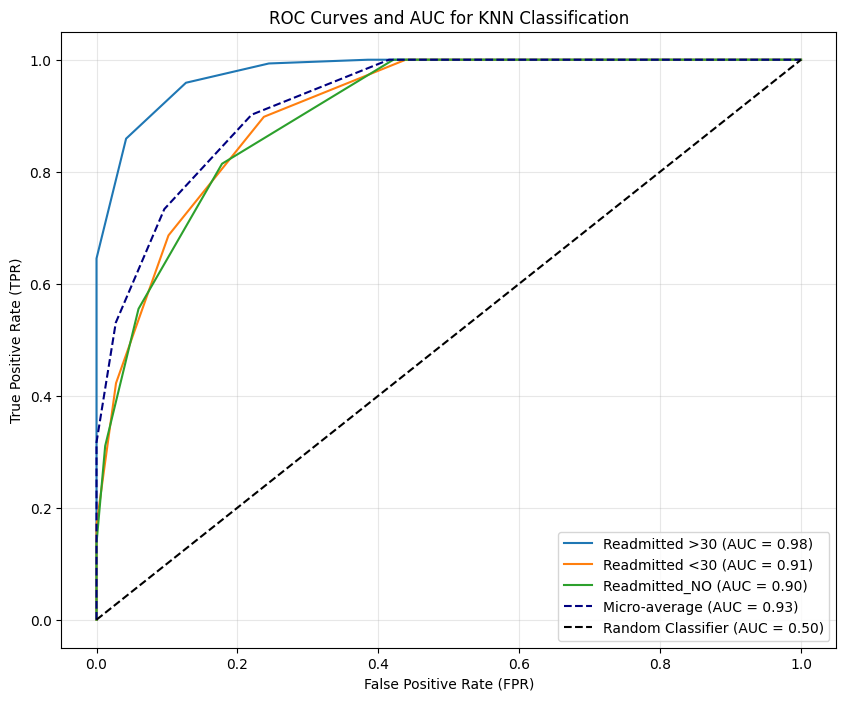

In [202]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = knn_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for KNN Classification")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

This models performs well on the training set, but slightly worse on the validation set, suggesting that overfitting might occur. Therefore, we are going to tune its hyperparameters to strike a balance between its performance and generalization.

---


Results for k=5:
Mean Training Score: 0.743 (+/- 0.001)
Mean Validation Score: 0.624 (+/- 0.011)
Score difference: 0.119

Results for k=6:
Mean Training Score: 0.712 (+/- 0.002)
Mean Validation Score: 0.608 (+/- 0.012)
Score difference: 0.105

Results for k=7:
Mean Training Score: 0.705 (+/- 0.001)
Mean Validation Score: 0.603 (+/- 0.013)
Score difference: 0.102

Results for k=8:
Mean Training Score: 0.681 (+/- 0.002)
Mean Validation Score: 0.589 (+/- 0.013)
Score difference: 0.092

Results for k=9:
Mean Training Score: 0.674 (+/- 0.002)
Mean Validation Score: 0.583 (+/- 0.011)
Score difference: 0.091

Results for k=10:
Mean Training Score: 0.662 (+/- 0.002)
Mean Validation Score: 0.577 (+/- 0.011)
Score difference: 0.085


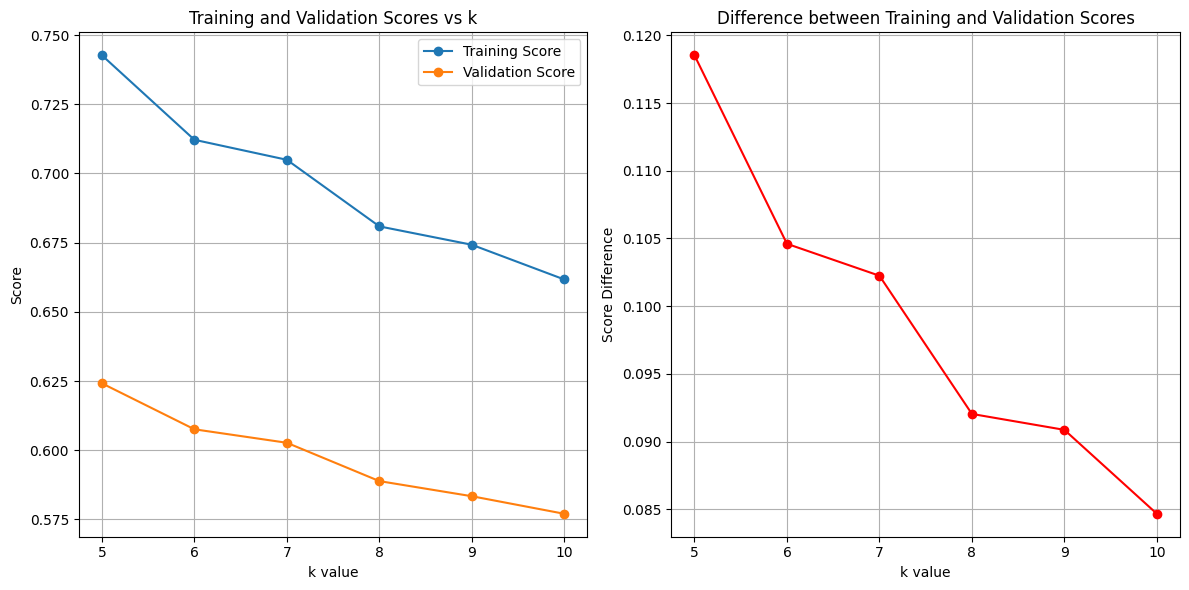

In [129]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_validate
import matplotlib.pyplot as plt
import numpy as np

# Range of k values to try
k_values = [5, 6, 7, 8, 9, 10]  # You can modify this list
results = {}

for k in k_values:
    # Train KNN model with different k
    knn_model = KNeighborsClassifier(
        n_neighbors=k,
        weights='uniform',
        algorithm='auto',
        leaf_size=30,
        p=2,
        metric='minkowski',
    )
    
    # Setup cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Get both training and validation scores
    cv_results = cross_validate(knn_model, X_train, y_train, 
                             cv=kf, 
                             scoring='accuracy',
                             return_train_score=True)
    
    difference = cv_results['train_score'].mean() - cv_results['test_score'].mean()
    
    # Store results for this k value
    results[k] = {
        'train_score': cv_results['train_score'].mean(),
        'train_std': cv_results['train_score'].std() * 2,
        'test_score': cv_results['test_score'].mean(),
        'test_std': cv_results['test_score'].std() * 2,
        'difference': difference
    }
    
    # Print results for each k
    print(f"\nResults for k={k}:")
    print(f"Mean Training Score: {cv_results['train_score'].mean():.3f} (+/- {cv_results['train_score'].std() * 2:.3f})")
    print(f"Mean Validation Score: {cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std() * 2:.3f})")
    print(f"Score difference: {difference:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
train_scores = [results[k]['train_score'] for k in k_values]
test_scores = [results[k]['test_score'] for k in k_values]
differences = [results[k]['difference'] for k in k_values]

# Plot training and validation scores
plt.subplot(1, 2, 1)
plt.plot(k_values, train_scores, marker='o', label='Training Score')
plt.plot(k_values, test_scores, marker='o', label='Validation Score')
plt.xlabel('k value')
plt.ylabel('Score')
plt.title('Training and Validation Scores vs k')
plt.legend()
plt.grid(True)

# Plot differences
plt.subplot(1, 2, 2)
plt.plot(k_values, differences, marker='o', color='red')
plt.xlabel('k value')
plt.ylabel('Score Difference')
plt.title('Difference between Training and Validation Scores')
plt.grid(True)

plt.tight_layout()
plt.show()


After conducting k-fold cross validation, we would pick 7 as our k value as it could strike a better balance between accuracy and generalization. 

---
Therefore, we would evaluate the model again but using 7 as our k value.


Model Performance:
Training Accuracy: 0.7117
Validation Accuracy: 0.6160
Accuracy Difference (Training - Validation): 0.0957
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.68      0.96      0.80     31552
readmitted_>30       0.71      0.65      0.68     31651
 readmitted_NO       0.78      0.52      0.62     31609

      accuracy                           0.71     94812
     macro avg       0.72      0.71      0.70     94812
  weighted avg       0.72      0.71      0.70     94812



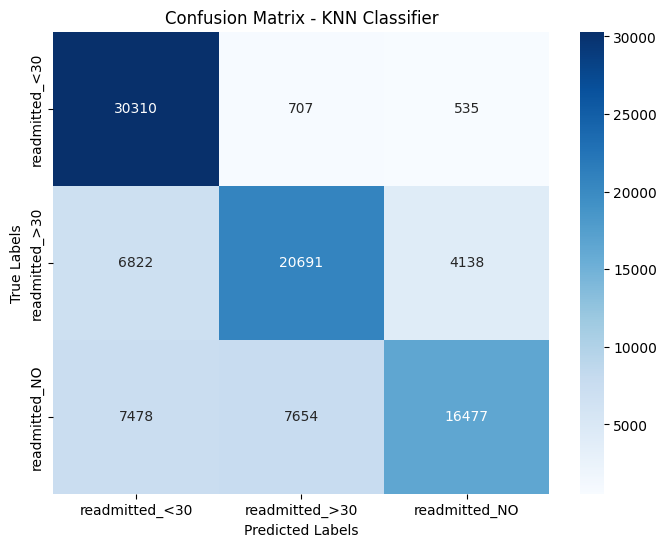

In [203]:
# Train KNN model
knn_model = KNeighborsClassifier(
    n_neighbors=7,  # You can adjust this parameter
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,  # Euclidean distance
    metric='minkowski',
)
knn_model.fit(X_train, y_train)

# Make predictions
y_train_pred = knn_model.predict(X_train)
y_val_pred = knn_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"],
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - KNN Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

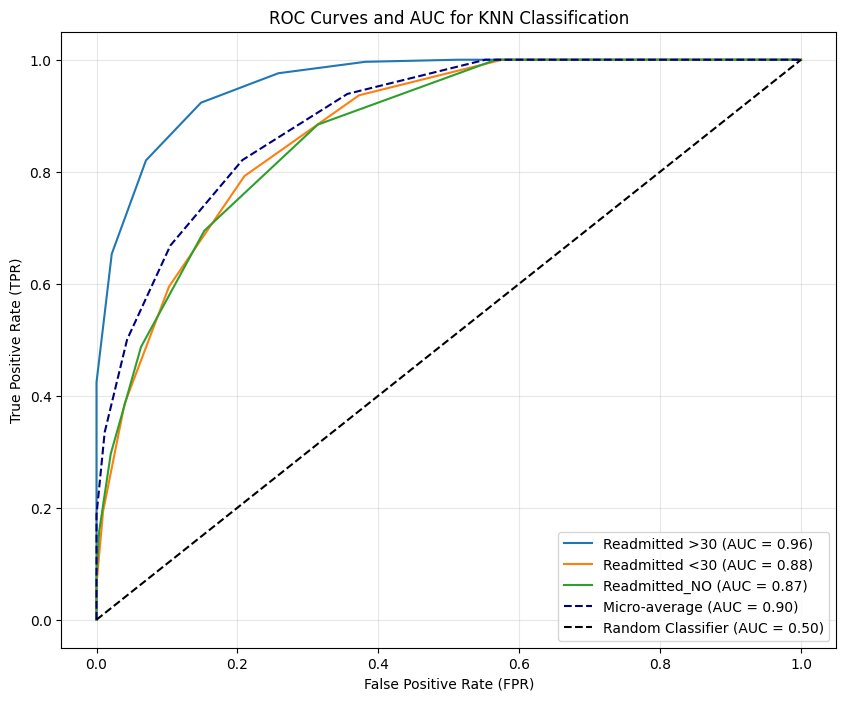

In [204]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = knn_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for KNN Classification")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## 4. XGBoost

Training XGBoost model...

Model Performance:
Training Accuracy: 0.6607
Validation Accuracy: 0.0000
Accuracy Difference (Training - Validation): 0.6607
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.92      0.13      0.23     10245
readmitted_>30       0.62      0.49      0.55     31989
 readmitted_NO       0.67      0.88      0.76     49355

      accuracy                           0.66     91589
     macro avg       0.74      0.50      0.51     91589
  weighted avg       0.68      0.66      0.63     91589



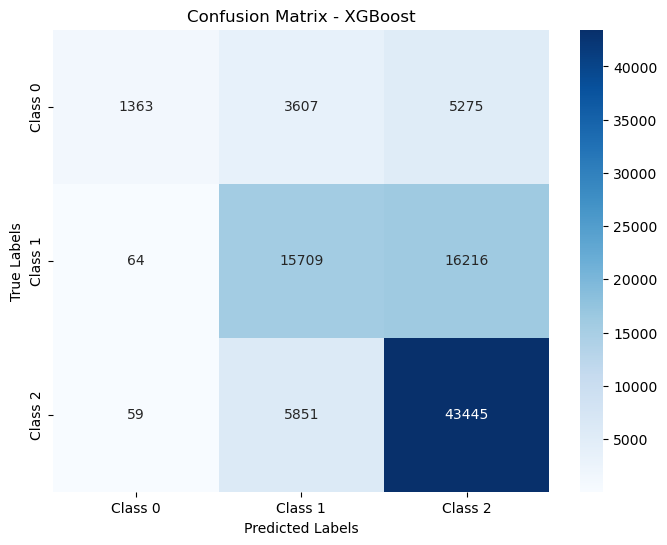

In [24]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=3,              
    eval_metric='mlogloss',     
    random_state=42,
    max_depth=8,
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


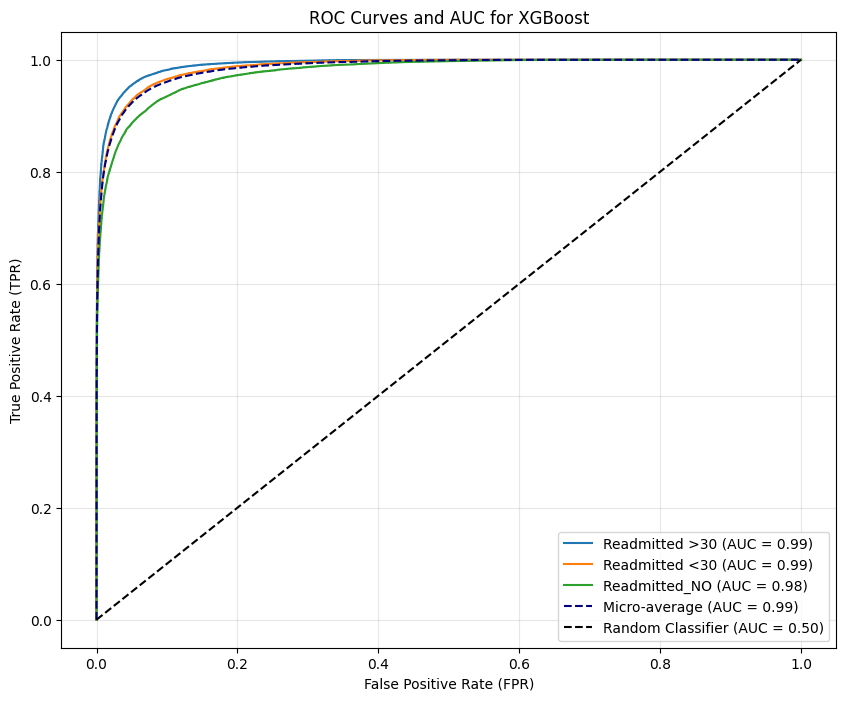

In [141]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = xgb_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for XGBoost")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

We could tell the XGBoost model performs very well on the training set, yet the overfitting problem is quite serious for this model, so we would try tuning the hyperarameters to lower the difference between training and validation accuracies while maintaining its quality performance.

---


Results for depth=3:
Mean Training Score: 0.532 (+/- 0.002)
Mean Validation Score: 0.497 (+/- 0.013)
Score difference: 0.035

Results for depth=4:
Mean Training Score: 0.587 (+/- 0.002)
Mean Validation Score: 0.524 (+/- 0.009)
Score difference: 0.063

Results for depth=5:
Mean Training Score: 0.663 (+/- 0.002)
Mean Validation Score: 0.557 (+/- 0.009)
Score difference: 0.106

Results for depth=6:
Mean Training Score: 0.751 (+/- 0.004)
Mean Validation Score: 0.591 (+/- 0.014)
Score difference: 0.160

Results for depth=7:
Mean Training Score: 0.846 (+/- 0.006)
Mean Validation Score: 0.628 (+/- 0.012)
Score difference: 0.218

Results for depth=8:
Mean Training Score: 0.927 (+/- 0.006)
Mean Validation Score: 0.662 (+/- 0.011)
Score difference: 0.265


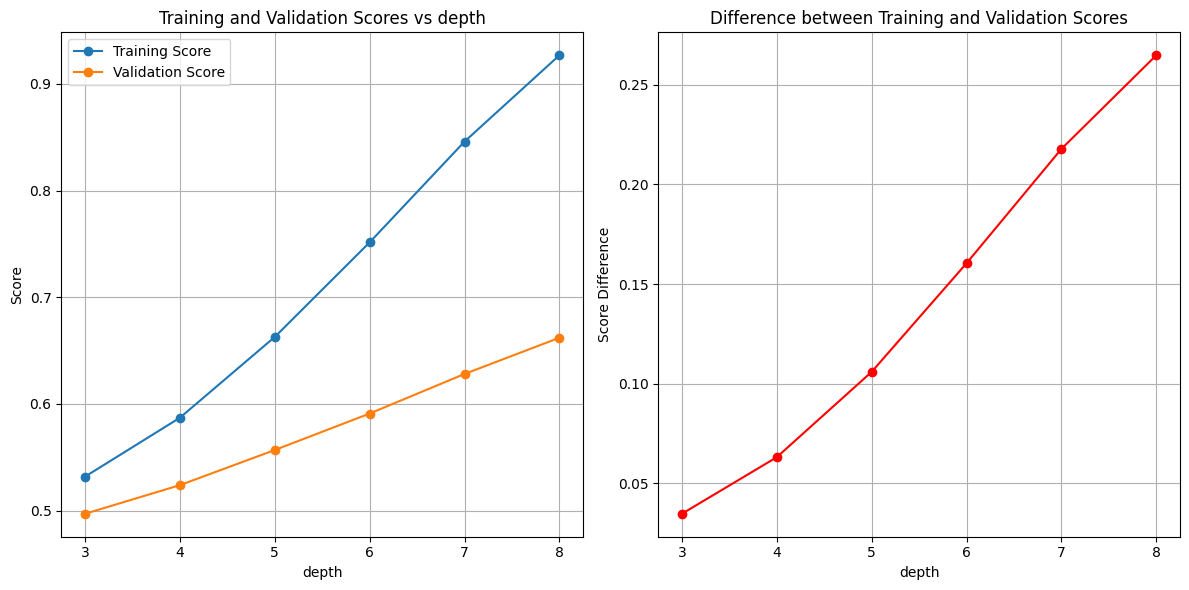

In [142]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_validate
import matplotlib.pyplot as plt
import numpy as np

# Range of k values to try
max_depth = [4, 5, 6, 7, 8]  # You can modify this list
results = {}

for depth in max_depth:
    # Train XGBoost model with different depths
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',  
        num_class=3,              
        eval_metric='mlogloss',     
        random_state=42,
        max_depth=depth
    )
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    cv_results = cross_validate(xgb_model, X_train, y_train, 
                             cv=kf, 
                             scoring='accuracy',
                             return_train_score=True)
    
    difference = cv_results['train_score'].mean() - cv_results['test_score'].mean()
    
    # Store results for this depth value
    results[depth] = {
        'train_score': cv_results['train_score'].mean(),
        'train_std': cv_results['train_score'].std() * 2,
        'test_score': cv_results['test_score'].mean(),
        'test_std': cv_results['test_score'].std() * 2,
        'difference': difference
    }
    
    # Print results for each depth
    print(f"\nResults for depth={depth}:")
    print(f"Mean Training Score: {cv_results['train_score'].mean():.3f} (+/- {cv_results['train_score'].std() * 2:.3f})")
    print(f"Mean Validation Score: {cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std() * 2:.3f})")
    print(f"Score difference: {difference:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
train_scores = [results[depth]['train_score'] for depth in max_depth]
test_scores = [results[depth]['test_score'] for depth in max_depth]
differences = [results[depth]['difference'] for depth in max_depth]

# Plot training and validation scores
plt.subplot(1, 2, 1)
plt.plot(max_depth, train_scores, marker='o', label='Training Score')
plt.plot(max_depth, test_scores, marker='o', label='Validation Score')
plt.xlabel('depth')
plt.ylabel('Score')
plt.title('Training and Validation Scores vs depth')
plt.legend()
plt.grid(True)

# Plot differences
plt.subplot(1, 2, 2)
plt.plot(max_depth, differences, marker='o', color='red')
plt.xlabel('depth')
plt.ylabel('Score Difference')
plt.title('Difference between Training and Validation Scores')
plt.grid(True)

plt.tight_layout()
plt.show()


After tuning its hyperparameter, we would choose 5 as the depth as it reduces the overfitting problem while maintaining an acceptable performance

---
Therefore, we would evaluate the model again using the new hyperparameter

Training XGBoost model...

Model Performance:
Training Accuracy: 0.6571
Validation Accuracy: 0.5614
Accuracy Difference (Training - Validation): 0.0956
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.68      0.73      0.71     31552
readmitted_>30       0.63      0.58      0.61     31651
 readmitted_NO       0.66      0.66      0.66     31609

      accuracy                           0.66     94812
     macro avg       0.66      0.66      0.66     94812
  weighted avg       0.66      0.66      0.66     94812



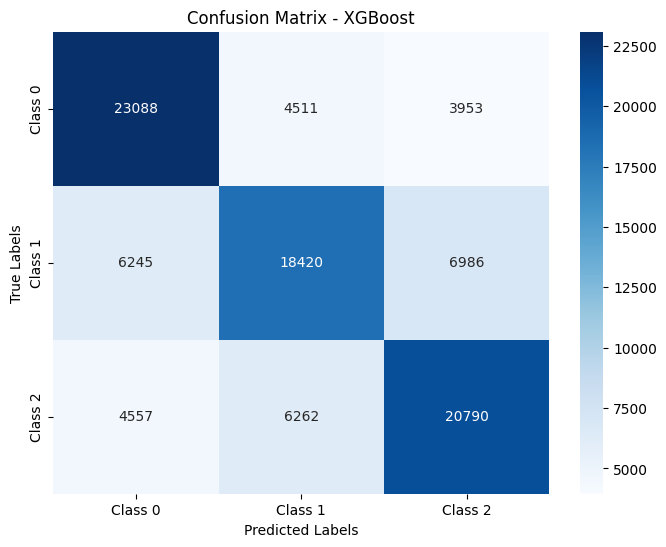

In [227]:
# Step 1: Train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=3,              
    eval_metric='mlogloss',     
    random_state=42,
    max_depth=5,
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

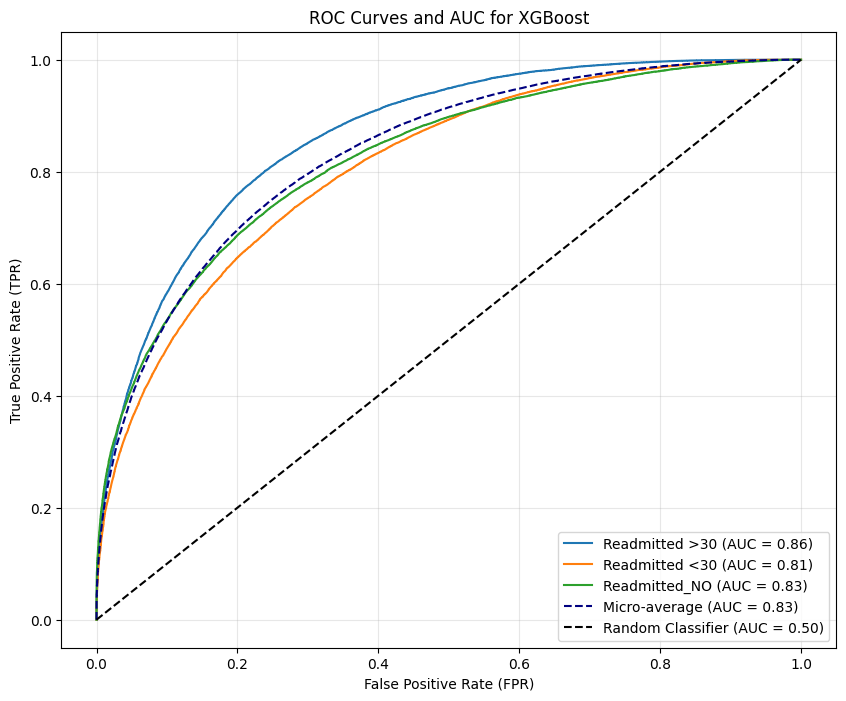

In [228]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = xgb_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for XGBoost")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## 5. Support Vector Machine

Training Support Vector Machine model...

Model Performance:
Training Accuracy: 0.4383
Validation Accuracy: 0.4397
Accuracy Difference (Training - Validation): -0.0014

Classification Report:
                precision    recall  f1-score   support

readmitted_<30       0.44      0.55      0.49     31552
readmitted_>30       0.38      0.17      0.23     31651
 readmitted_NO       0.46      0.60      0.52     31609

      accuracy                           0.44     94812
     macro avg       0.43      0.44      0.41     94812
  weighted avg       0.43      0.44      0.41     94812



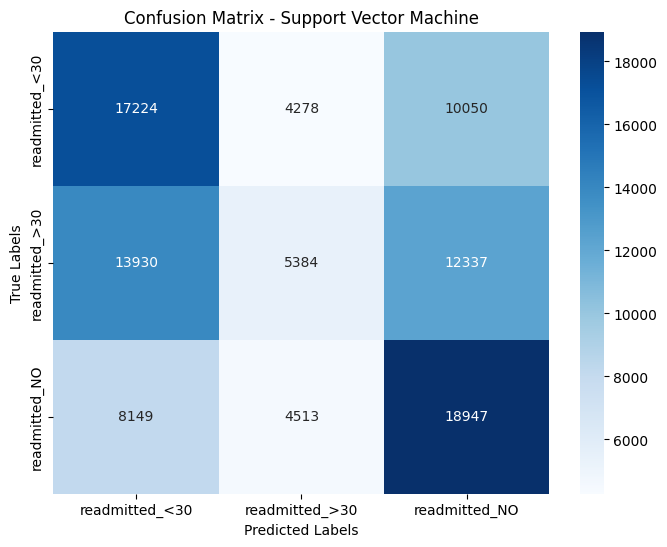

In [156]:
from sklearn.linear_model import SGDClassifier

# Step 1: Train Support Vector Machine model 
print("Training Support Vector Machine model...")
svm_model = SGDClassifier(
    loss='hinge',
    random_state=42,
    max_iter=1000,
    tol=0.0001,
    n_jobs=-1,
    
)

svm_model.fit(X_train, y_train)

# Make predictions
y_train_pred = svm_model.predict(X_train)
y_val_pred = svm_model.predict(X_val)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Create and plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], 
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - Support Vector Machine")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

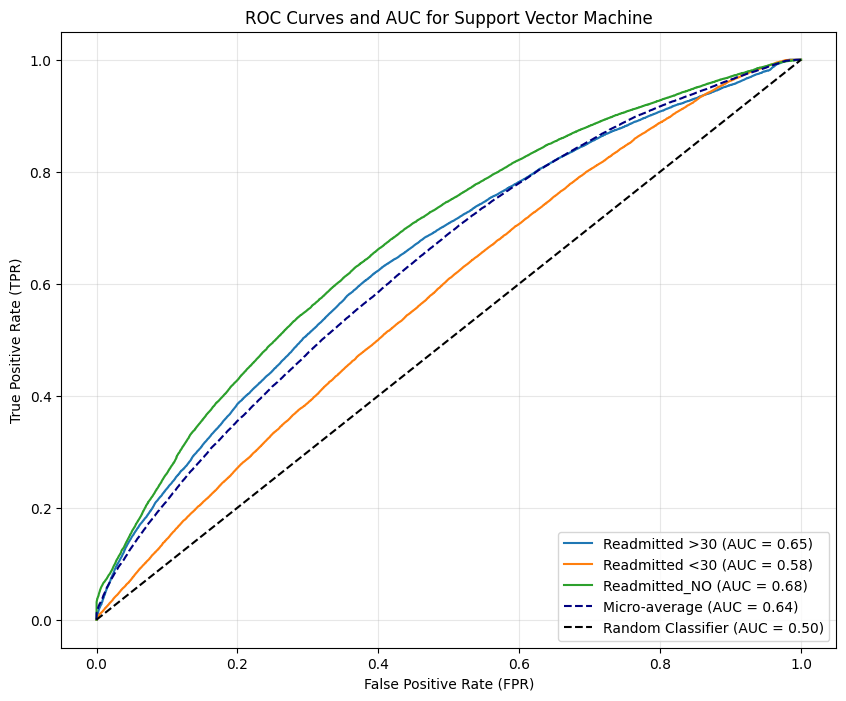

In [158]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Calibrate the model so that we could get probability predictions
calibrated_svm = CalibratedClassifierCV(svm_model, cv=5)
calibrated_svm.fit(X_train, y_train)

# Get probability predictions
y_pred_proba = calibrated_svm.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Support Vector Machine")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

We could conclude that this model has no overfitting problem, yet it has the worst performance by far, therefore we wouldn't be tuning its hyperparameters to improve its accuracy and would proceed to the next model

## 6. Random Forest

Training Random Forest model...

Model Performance:
Training Accuracy: 0.9801
Validation Accuracy: 0.7062
Accuracy Difference (Training - Validation): 0.2739

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.97      0.99      0.98     31552
     Class 1       0.98      0.98      0.98     31651
     Class 2       0.99      0.97      0.98     31609

    accuracy                           0.98     94812
   macro avg       0.98      0.98      0.98     94812
weighted avg       0.98      0.98      0.98     94812



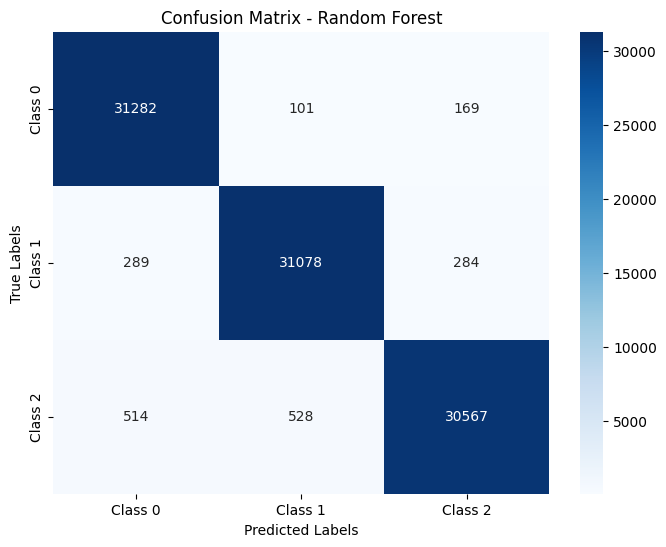

In [207]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=80,  
    random_state=42,     
    max_depth=20,      
    class_weight="balanced"  
)

rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")

# Step 3: Classification Report
print("\nClassification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["Class 0", "Class 1", "Class 2"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

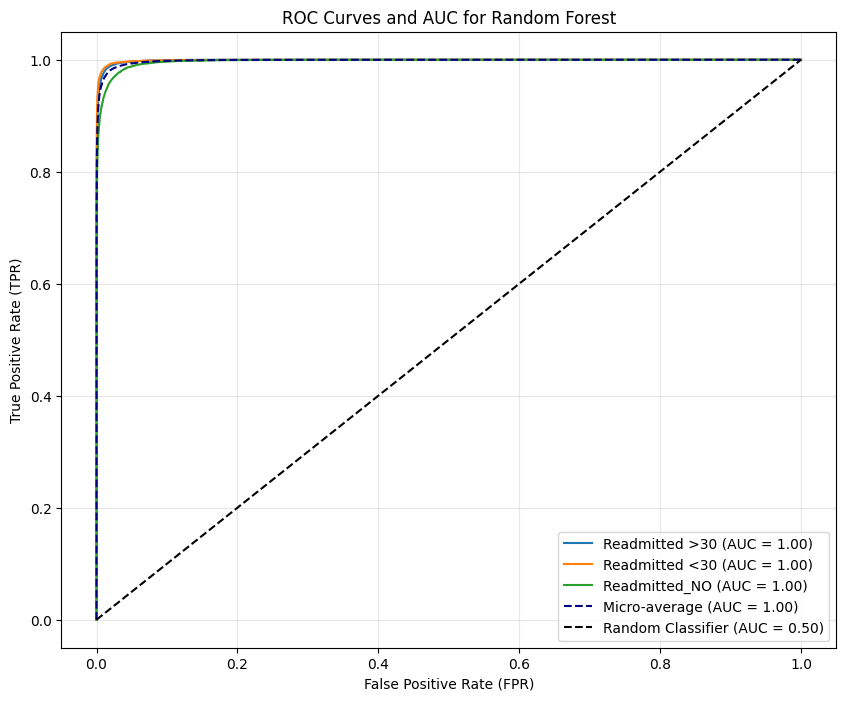

In [176]:
# Step 5: ROC and AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = rf_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Random Forest")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

This model is by far the best one regarding accuracy, yet it has the most serious overfitting problem, therefore we would have to tune its hyperparameters to lessen the overfitting issue

---


Results for depth=5:
Mean Training Score: 0.458 (+/- 0.002)
Mean Validation Score: 0.449 (+/- 0.012)
Score difference: 0.009

Results for depth=8:
Mean Training Score: 0.513 (+/- 0.002)
Mean Validation Score: 0.479 (+/- 0.016)
Score difference: 0.034

Results for depth=12:
Mean Training Score: 0.679 (+/- 0.006)
Mean Validation Score: 0.549 (+/- 0.016)
Score difference: 0.129

Results for depth=15:
Mean Training Score: 0.838 (+/- 0.006)
Mean Validation Score: 0.619 (+/- 0.009)
Score difference: 0.219

Results for depth=20:
Mean Training Score: 0.980 (+/- 0.003)
Mean Validation Score: 0.693 (+/- 0.012)
Score difference: 0.287


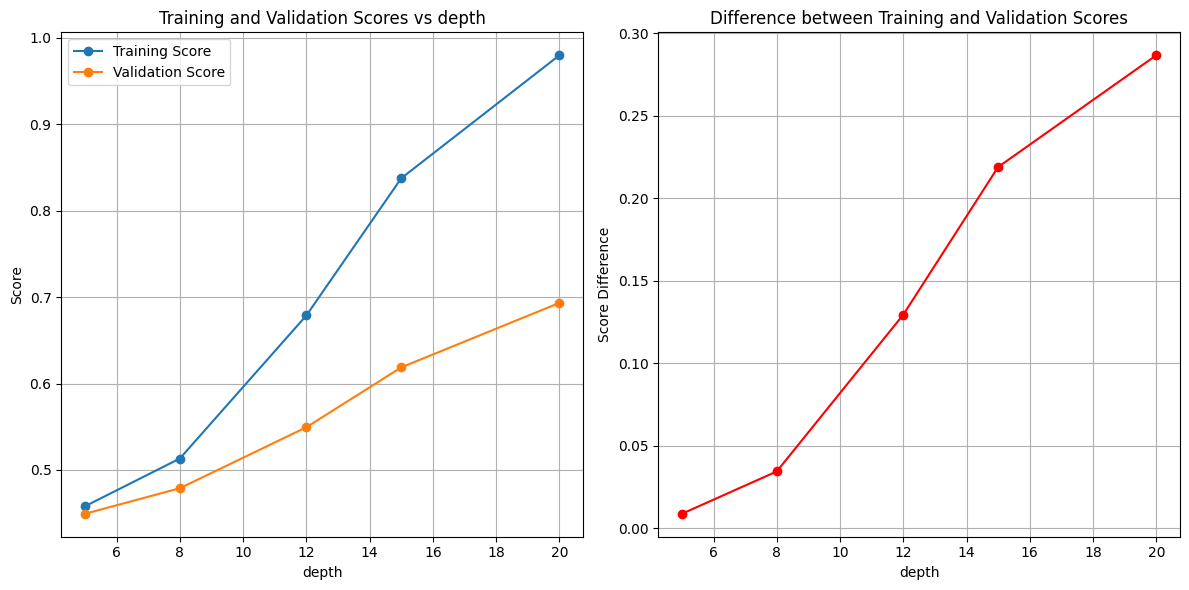

In [172]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_validate
import matplotlib.pyplot as plt
import numpy as np

# Range of k values to try
max_depth = [5, 8, 12, 15, 20]  # You can modify this list
results = {}

for depth in max_depth:
    # Train random forest model with different depths
    rf_model = RandomForestClassifier(
        n_estimators=80,  
        random_state=42,     
        max_depth=depth,      
        class_weight="balanced"  
    )
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    cv_results = cross_validate(rf_model, X_train, y_train, 
                             cv=kf, 
                             scoring='accuracy',
                             return_train_score=True)
    
    difference = cv_results['train_score'].mean() - cv_results['test_score'].mean()
    
    # Store results for this depth value
    results[depth] = {
        'train_score': cv_results['train_score'].mean(),
        'train_std': cv_results['train_score'].std() * 2,
        'test_score': cv_results['test_score'].mean(),
        'test_std': cv_results['test_score'].std() * 2,
        'difference': difference
    }
    
    # Print results for each depth
    print(f"\nResults for depth={depth}:")
    print(f"Mean Training Score: {cv_results['train_score'].mean():.3f} (+/- {cv_results['train_score'].std() * 2:.3f})")
    print(f"Mean Validation Score: {cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std() * 2:.3f})")
    print(f"Score difference: {difference:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
train_scores = [results[depth]['train_score'] for depth in max_depth]
test_scores = [results[depth]['test_score'] for depth in max_depth]
differences = [results[depth]['difference'] for depth in max_depth]

# Plot training and validation scores
plt.subplot(1, 2, 1)
plt.plot(max_depth, train_scores, marker='o', label='Training Score')
plt.plot(max_depth, test_scores, marker='o', label='Validation Score')
plt.xlabel('depth')
plt.ylabel('Score')
plt.title('Training and Validation Scores vs depth')
plt.legend()
plt.grid(True)

# Plot differences
plt.subplot(1, 2, 2)
plt.plot(max_depth, differences, marker='o', color='red')
plt.xlabel('depth')
plt.ylabel('Score Difference')
plt.title('Difference between Training and Validation Scores')
plt.grid(True)

plt.tight_layout()
plt.show() 


---

## Final evaluation

(18318,)
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.20      0.38      0.26      2100
readmitted_>30       0.45      0.41      0.43      6368
 readmitted_NO       0.67      0.57      0.62      9850

      accuracy                           0.49     18318
     macro avg       0.44      0.46      0.44     18318
  weighted avg       0.54      0.49      0.51     18318



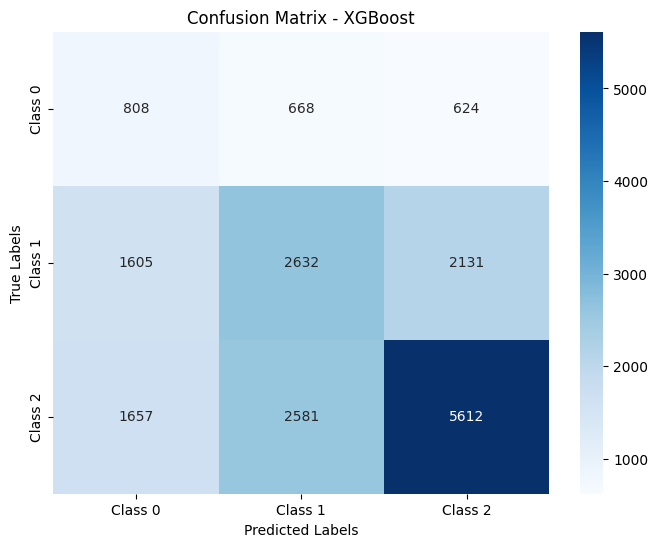

In [230]:
print(y_test.shape)

X_test = X_test_final.copy()
y_test = y_test_encoded.copy()

y_pred = xgb_model.predict(X_test)


print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Super Learners

- DNN
- etc.